In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D
%matplotlib inline

## Where the magic happens

##### Calculate the T_tot matrix, the outcomming waves and find the coefficients

The waves are normalized by the current $<I>=2\operatorname{Im}(\psi_n^*\psi_{n+1})$

In [2]:
N = 30 # number of transverse lattice points
L = 10 # Length of system
t = 1 # coupling constant
mu = 0.2 # chemical potential of the leads


def T(mu, N):
    """ This function generates a transfer matrix for a potential V. """
    T12 = np.zeros((N,N))
    T21 = np.zeros((N,N))
    T22 = np.zeros((N,N))
    np.fill_diagonal(T12, -1)
    np.fill_diagonal(T21, t)
    v = np.ones(N-1)
    H = np.diag(-t*v,-1) + np.diag( (4*t)*np.ones(N)-mu,0) + np.diag(-t*v,1)
    T11 = H/t
    return np.array(np.bmat([[T11, T12], [T21, T22]]))


def solve(mu, L, N):
    # find the eigenvalues and vectors
    eig_val, eig_vec = np.linalg.eig(T(mu, N))

    # get indices of the forward and backward propagating waves and the evanescent growing and decaying waves
    idx_R = np.where(eig_val.imag > 0.)[0] # waves that propagate right
    idx_L = np.where(eig_val.imag < 0.)[0] # waves that propagate left
    idx_evan = np.where(eig_val.imag == 0)[0] # evanescent waves
    idx_grow = np.where(np.abs(eig_val[idx_evan]) > 1)[0] # evanescent growing waves
    idx_dec = np.where(np.abs(eig_val[idx_evan]) < 1)[0] # evanescent decaying waves

    #T_tot = T(np.random.rand(N)) # overwrite the transfer matrix
    T_tot = np.eye(2*N)
    for j in range(L):
        T_tot = np.dot(T(mu, N), T_tot)

    psi_R = eig_vec[:,idx_R]
    psi_L = eig_vec[:,idx_L]
    ev_dec = eig_vec[:,idx_evan][:,idx_dec]
    ev_grow = eig_vec[:,idx_evan][:,idx_grow]

    psi_R_norm = 2 * np.sum(np.multiply(np.conjugate(psi_R[N:2*N]) , psi_R[:N]), axis=0).imag 
    psi_R /= np.sqrt(psi_R_norm)
    psi_L_norm = -2 * np.sum(np.multiply(np.conjugate(psi_L[N:2*N]) , psi_L[:N]), axis=0).imag
    psi_L /= np.sqrt(psi_L_norm)

    U_L = np.hstack((psi_R, ev_dec, np.dot(-T_tot,psi_L), np.dot(-T_tot,ev_grow) ))
    U_R = np.dot(T_tot, psi_R)

    coeff = np.dot(np.linalg.inv(U_L), U_R)

    N_in = psi_L.shape[1] # number of incomming waves
    N_ev = ev_dec.shape[1] # number of evanescent waves

    t_matrix = coeff[:N_in,:]
    alpha = coeff[N_in:N_in+N_ev,:]
    r = coeff[N_in+N_ev:2*N_in+N_ev,:]
    beta = coeff[2*N_in+N_ev:2*N_in+2*N_ev,:]
    
    test = np.sum(abs(t_matrix)**2+abs(r)**2, axis=0)
    test2 = np.sum(test)/len(test)
    
    return test2

In [3]:
L_max = 100
lengths = np.arange(0,L_max,1)
error = np.zeros(L_max)
for L in lengths:
    error[L] = solve(mu=0.2, L=L, N=100)

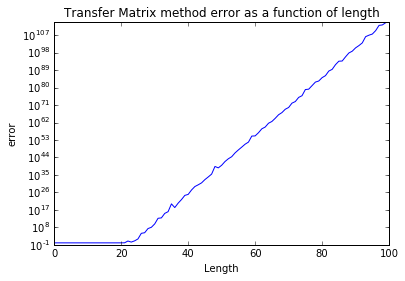

In [4]:
fig = plt.figure()
ax = plt.gca()
ax.set_yscale('log')
plt.plot(lengths, error)
plt.title('Transfer Matrix method error as a function of length')
plt.xlabel('Length')
plt.ylabel('error')

## Generate a smooth potential

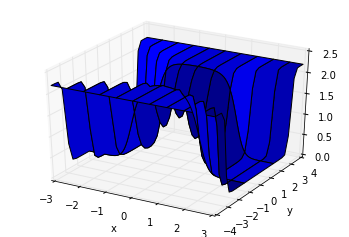

In [5]:
# generate potential
x = np.linspace(-3,3,L)
y = np.linspace(-4,4,N)
X, Y = np.meshgrid(x,y)
pot = np.tanh(Y**2-X**2)+1+mu

# plot the potential
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='3d')
plt.xlabel('x')
plt.ylabel('y')
p = ax.plot_surface(X, Y, pot)
plt.show()

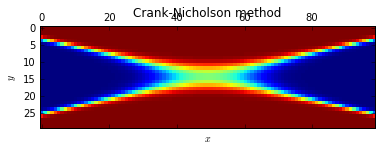

In [6]:
fig, ax = plt.subplots()
plot = ax.matshow(pot)
title = ax.set_title("Crank-Nicholson method")
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()